In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime

import bokeh
from bokeh.layouts import Row, column, gridplot
from bokeh.models import Title, Legend, TapTool, Range1d, TabPanel, Tabs
import matplotlib as mpl

from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)
from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.models import Span


In [2]:
color_palette = [  '#4E79A7',  # Blue
    '#F28E2B',  # Orange
    '#E15759',  # Red
    '#76B7B2',  # Teal
    '#59A14F',  # Green
    '#EDC948',  # Yellow
    '#B07AA1',  # Purple
    '#FF9DA7',  # Pink
    '#9C755F',  # Brown
    '#BAB0AC',  # Gray
    '#7C7C7C',  # Dark gray
    '#6B4C9A',  # Violet
    '#D55E00',  # Orange-red
    '#CC61B0',  # Magenta
    '#0072B2',  # Bright blue
    '#329262',  # Peacock green
    '#9E5B5A',  # Brick red
    '#636363',  # Medium gray
    '#CD9C00',  # Gold
    '#5D69B1',  # Medium blue
]

In [3]:
bokeh.core.validation.silence(EMPTY_LAYOUT, True)

def get_line_plot(ooklaUsers,title, source, earthquakes=False, subtitle=None, measure = 'conflictIndex', category = 'DT'):

    p2 = figure(x_axis_type = 'datetime', width = 1000, height = 400, toolbar_location='above')
    p2.add_layout(Legend(), "right")

    for id, adm2 in enumerate(ooklaUsers[category].unique()):
        df = ooklaUsers[ooklaUsers[category]==adm2][['event_date_map', measure]].reset_index(drop=True)
        p2.line(df['event_date_map'], df[measure], line_width=2, line_color = color_palette[id], legend_label=adm2)

    p2.legend.click_policy='hide'
    if subtitle is not None:
        p2.title = subtitle


    title_fig = figure(title=title, toolbar_location=None,width=800, height=40, )
    title_fig.title.align = "left"
    title_fig.title.text_font_size = "20pt"
    title_fig.border_fill_alpha = 0
    title_fig.outline_line_width=0

    #with silence(MISSING_RENDERERS):
    sub_title = figure(title=source, toolbar_location=None,width=800, height=40, )
    sub_title.title.align = "left"
    sub_title.title.text_font_size = "10pt"
    sub_title.title.text_font_style="normal"
    sub_title.border_fill_alpha = 0
    sub_title.outline_line_width=0

    layout = column(title_fig, p2, sub_title)

    if earthquakes:
        p2.renderers.extend([
        Span(
            location=datetime(2020, 3, 15),
            dimension="height",
            line_color='#7C7C7C',
            line_width=2,
            line_dash=(4,4)
      ),
        Span(
            location=datetime(2021, 2, 15),
            dimension="height",
            line_color='#7C7C7C',
            line_width=2,
            line_dash=(4,4)
        ),
    ]
)

    return layout

# Armed Conflict Location and Event Data Analysis

The Armed Conflict Location & Event Data Project (ACLED) is a disaggregated data collection, analysis, and crisis mapping project. ACLED collects information on the dates, actors, locations, fatalities, and types of all reported political violence and protest events around the world. The raw data is available through a license obtained by the World Bank

In [4]:
myanmar_adm3 = gpd.read_file('../../data/shapefiles/mmr_polbnda_adm3_250k_mimu/mmr_polbnda_adm3_250k_mimu.shp')
myanmar_adm2 = gpd.read_file('../../data/shapefiles/mmr_polbnda_adm2_250k_mimu_1/mmr_polbnda_adm2_250k_mimu_1.shp')
myanmar_adm1 = gpd.read_file('../../data/shapefiles/mmr_polbnda2_adm1_250k_mimu/mmr_polbnda2_adm1_250k_mimu.shp')

sez = gpd.read_file('../../data/shapefiles/industrial__special_economic_zones_sept2019/industrial__special_economic_zones_sept2019.shp')
sez_hdx = gpd.read_file('../../data/shapefiles/industrial__special_economic_zones_sept2019_hdx/industrial__special_economic_zones_sept2019.shp')
ntl_sez = pd.read_csv('../../data/night-time-lights/admsez_VNP46A3.csv')
ntl_adm2 = pd.read_csv('../../data/night-time-lights/adm2_VNP46A3.csv')
ntl_adm3 = pd.read_csv('../../data/night-time-lights/adm3_VNP46A4.csv')
ntl_adm1 = pd.read_csv('../../data/night-time-lights/adm1_VNP46A3.csv')

acled = pd.read_csv('../../data/conflict/2012-01-01-2023-05-16-Myanmar.csv')
conflict = pd.read_csv('../../data/conflict/conflict_data_mmr.csv')

In [5]:
myanmar_sez = gpd.read_file('../../data/shapefiles/industrial__special_economic_zones_sept2019_hdx/industrial__special_economic_zones_sept2019.shp')

In [6]:
from datetime import datetime

acled['event_date'] = acled['event_date'].apply(lambda x: datetime.strptime(x, '%d %B %Y'))
acled['country'] = 'MMR'

Removing conflict data from strategic developments after the Mynmar Country team had consultations with a team onground monitoring the conflict

In [7]:
acled = acled[acled['event_type']!='Strategic developments']
acled = acled[acled['event_date']>='2020-01-01']

## Calculating Conflict Index

Conflict Index is calculated as a geometric mean of conflict events and fatalities at admin 2 level

In [8]:
from shapely.geometry import Point

def convert_to_gdf(df):
    geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
    gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)

    return gdf

In [9]:
import numpy as np
from scipy.stats import gmean

def get_acled_by_admin(myanmar_adm2, acled, columns = ['DT','DT_PCODE','ST'], nearest=False, freq = 'M'):
    acled_adm2 = convert_to_gdf(acled)
    if nearest == True:
        acled_adm2 = myanmar_adm2.sjoin_nearest(acled_adm2)[[ 'event_date', 'fatalities', 'event_type' ]+columns].groupby([pd.Grouper(key='event_date', freq=freq, closed='left')]+columns)['fatalities'].agg(['sum', 'count']).reset_index()
    else:
        acled_adm2 = myanmar_adm2.sjoin(acled_adm2)[[ 'event_date', 'fatalities', 'event_type' ]+columns].groupby([pd.Grouper(key='event_date', freq=freq, closed='left')]+columns)['fatalities'].agg(['sum', 'count']).reset_index()
    acled_adm2.rename(columns = {'sum':'fatalities', 'count':'nrEvents'}, inplace=True)
    acled_adm2['conflictIndex'] = acled_adm2.apply(lambda row: gmean([row['nrEvents'], row['fatalities']]), axis=1)

    if freq == 'M':
        acled_adm2['event_date_map'] = acled_adm2['event_date'].apply(lambda x: x.date().replace(day=1))
    else:
        acled_adm2['event_date_map'] = acled_adm2['event_date'].apply(lambda x: x.date().replace(day=1))
        acled_adm2['event_date_map'] = acled_adm2['event_date'].apply(lambda x: x.date().replace(month=1))

    return acled_adm2.reset_index()
#.pivot(index = 'DT_PCODE', columns='event_date').sort_values(by='DT_PCODE')

In [10]:
acled_adm1 = get_acled_by_admin(myanmar_adm1, acled, columns = ['ST', 'ST_PCODE'])
acled_adm2 = get_acled_by_admin(myanmar_adm2, acled)
acled_adm0 = get_acled_by_admin(myanmar_adm1, acled, columns = ['country'], freq = 'Y')

c:\Users\sahit\anaconda3\envs\turkey-rdna\lib\site-packages\geopandas\geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...
Right CRS: EPSG:4326

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
c:\Users\sahit\anaconda3\envs\turkey-rdna\lib\site-packages\geopandas\geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...
Right CRS: EPSG:4326

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
c:\Users\sahit\anaconda3\envs\turkey-rdna\lib\site-packages\geopandas\geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of lef

In [11]:
def get_size_category(item):
    if item < 20:
        return 5
    elif item < 50:
        return 30
    elif item < 100:
        return 40
    elif item < 200:
        return 100
    else:
        return 150

In [12]:
sizeCategoryLabels = {5:'Less than 20', 30:'Less than 50', 40:'Less than 100', 100:'Less than 200', 150: 'More than 200'}

In [13]:
def get_acled_conflicts_by_year(acled, start_date, end_date):
    acled_22 = acled[(acled['event_date']>=start_date)&(acled['event_date']<=end_date)]
    acled_22 = acled_22.groupby(['latitude', 'longitude', pd.Grouper(key='event_date', freq='Y')])['fatalities'].agg(['sum', 'count']).reset_index()
    acled_22 = convert_to_gdf(acled_22)
    acled_22['sizeCategory'] = acled_22['sum'].apply(lambda x: get_size_category(x))
    acled_22.sort_values(by='count')

    return acled_22

In [14]:
acled_21 = get_acled_conflicts_by_year(acled, '2021-01-01', '2021-12-31')
acled_22 = get_acled_conflicts_by_year(acled, '2022-01-01', '2022-12-31')
acled_23 = get_acled_conflicts_by_year(acled, '2023-01-01', '2023-12-31')

## Geospatial Changes in Conflict in Myanmar from 2021 to 2022

The below plot shows a map of Myanmar and the conflicts that occured in 2021 and 2022. The size of each bubble indicates the number of events while the color indicates the number of fatalities. 

The following observations can be made from the below map and the following line plot - 
* The number of documented conflicts were the highest in 2021 but the number of deaths were the highest in 2022
* In 2022, Sagaing had a lot more conflicts than in 2021 showing a 60% increase
* Through visual inspection, conflicts were slightly more spread out in 2022 than 2021
* This could indicate that some of the events caused severe damage in 2022
* The areas where there were high damage remained the same in 2021 and 2022, focussed in the Sagaing and Magway regions
* In 2021, the most number of events were in Mandalay followed by Yinmarbin, in 2022, most conflicts were in Yinmarbin followed by Shwebo
* In 2021, the most fatalities were in Yinmarbin followed by Kale, in 2022, most fatalities were in Yinmarbin followed by Shwebo
* Regions that saw less conflict in 2021 like Shan (East) continued to see less conflict in 2022 as well, compared to the other regions. 

In [15]:
myanmar_adm1['coords'] = myanmar_adm1['geometry'].apply(lambda x: x.representative_point().coords[:])
myanmar_adm1['coords'] = [coords[0] for coords in myanmar_adm1['coords']]

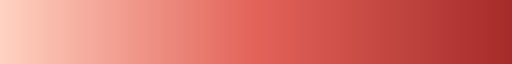

In [16]:
from matplotlib.colors import LinearSegmentedColormap

# Define the color gradient segments
colors = [(0.0, '#FFD2C1'), (0.5, '#E36359'), (1.0, '#A62C2B')]

# Create the colormap using LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('custom_colormap', colors)
cmap

C:\Users\sahit\AppData\Local\Temp\ipykernel_23336\1745098067.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


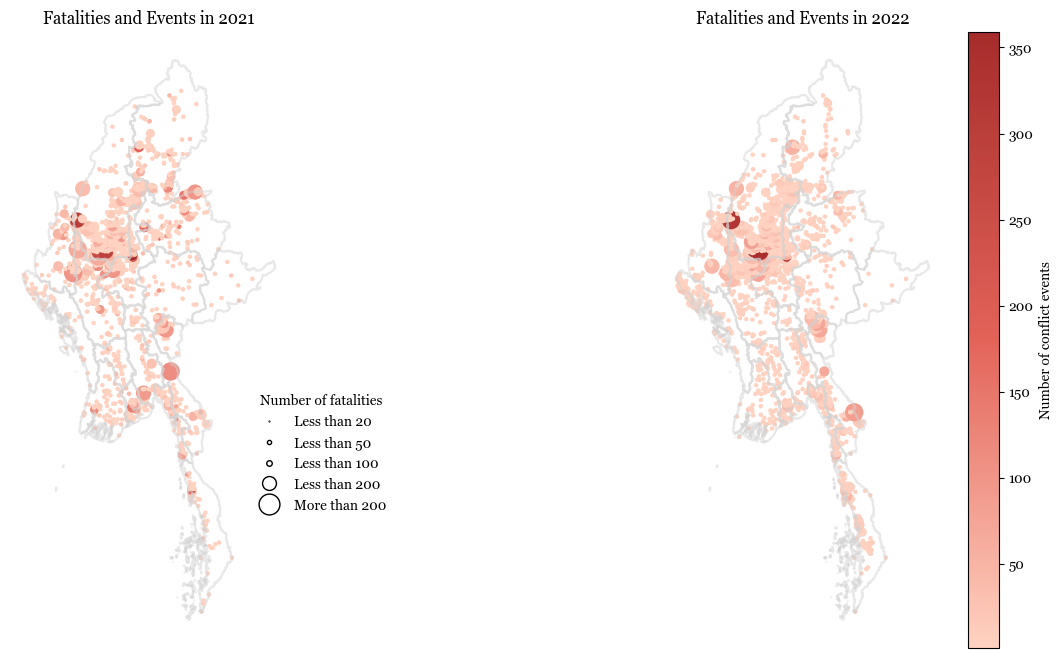

In [17]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

plt.rcParams["font.family"] = "Georgia"

fig, ax = plt.subplots(1,2, sharex=True, figsize =(15, 8))


acled_21.plot(column = 'count', cmap = cmap,  ax = ax[0], markersize = 'sizeCategory', marker = 'o')
myanmar_adm1.boundary.plot(ax=ax[0], color = 'lightgrey', alpha = 0.5, zorder=1)
ax[0].set_title('Fatalities and Events in 2021')

acled_22.plot(column = 'count',  cmap = cmap, ax = ax[1], markersize = 'sizeCategory')
myanmar_adm1.boundary.plot(ax=ax[1], color = 'lightgrey', alpha = 0.5, zorder = 1)
ax[1].set_title('Fatalities and Events in 2022')

# acled_23.plot(column = 'sum',  cmap = 'Reds', ax = ax[2], markersize = 'sizeCategory', vmin=10, vmax = 300)
# myanmar_adm1.boundary.plot(ax=ax[2], color = 'lightgrey', alpha = 0.5, zorder = 1)

# for idx, row in myanmar_adm1.iterrows():
#     print(row['ST'])
#     ax[1].annotate(text=row['ST'], xy=row['coords'],
#                  horizontalalignment='center')
#ax[2].set_title('Fatalities and Events in 2023')

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array(acled_22['count'])
cbar = plt.colorbar(sm)
cbar.set_label("Number of conflict events")

for i in [0,1]:
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

    ax[i].set_xticks([])
    ax[i].set_yticks([])

sizes = acled_22.sort_values(by='sizeCategory')['sizeCategory'].unique()
handles = []
for size in sizes:
    handle, = ax[0].plot([], [], marker='o', markersize=size/10, linestyle='', label=sizeCategoryLabels[size], markerfacecolor='white', markeredgecolor='black')
    handles.append(handle)
ax[0].legend(handles=handles, title='Number of fatalities', loc='lower right', frameon=False, bbox_to_anchor = (1.4,0.2))
plt.show()
    #ax[i].set_xticks(False)

### Top 5 worst affected admin 1 regions in 2021

In [18]:
acled_adm1[acled_adm1['event_date'].between('2022-01-01', '2022-12-31')].groupby([pd.Grouper(key = 'event_date', freq = 'Y'), 'ST']).sum(['fatalities', 'nrEvents']).reset_index().sort_values(by='nrEvents', ascending = False)[['event_date', 'ST', 'fatalities', 'nrEvents']].head(5)


,event_date,ST,fatalities,nrEvents
12,2022-12-31,Sagaing,8204,4211
8,2022-12-31,Mandalay,1048,1000
7,2022-12-31,Magway,2424,953
16,2022-12-31,Tanintharyi,1042,746
17,2022-12-31,Yangon,317,731


### Top 5 worst affected admin 1 regions in 2021

In [19]:
acled_adm1[acled_adm1['event_date'].between('2021-01-01', '2021-12-31')].groupby([pd.Grouper(key = 'event_date', freq = 'Y'), 'ST']).sum(['fatalities', 'nrEvents']).reset_index().sort_values(by='nrEvents', ascending = False)[['event_date', 'ST', 'fatalities', 'nrEvents']].head(5)

,event_date,ST,fatalities,nrEvents
12,2021-12-31,Sagaing,4275,2609
17,2021-12-31,Yangon,484,1841
8,2021-12-31,Mandalay,683,1719
14,2021-12-31,Shan (North),505,1181
4,2021-12-31,Kachin,648,1128


In [20]:
output_notebook()
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []

#df = get_acled_by_admin(myanmar_adm1, acled, columns = ['country'])
for type in ['nrEvents', 'fatalities']:

    tabs.append(
        TabPanel(
        child=get_line_plot(acled_adm0, f"{type.capitalize()} in the country", "Source: ACLED", earthquakes=True, subtitle = '', category = 'country', measure = type),
                    title=type.capitalize(),
                )
                )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

In [21]:
output_notebook()
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []

tabs.append(
    TabPanel(
    child=get_line_plot(acled_adm1, f"Conflict Index by admin 1", "Source: ACLED", earthquakes=True, subtitle = '', category = 'ST'),
                #title=adm.capitalize(),
            )
            )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

In [22]:
output_notebook()
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)


tabs = []

for adm in list(acled_adm2['ST'].unique()):
    df = acled_adm2[acled_adm2['ST']==adm] 

    tabs.append(
        TabPanel(
        child=get_line_plot(df, f"Conflict Index by admin 2", "Source: ACLED", earthquakes=True, subtitle = ''),
                    title=adm.capitalize(),
                )
                )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

## Observe trends between nightlights and ACLED data

In [23]:
ntl_sez['date'] = ntl_sez['date'].apply(lambda x: datetime.strptime(x,  '%d/%m/%Y'))
ntl_adm1['date'] = ntl_adm1['date'].apply(lambda x: datetime.strptime(x,   '%Y-%m-%d'))
ntl_adm2['date'] = ntl_adm2['date'].apply(lambda x: datetime.strptime(x,   '%Y-%m-%d'))
ntl_adm2['date_map'] = ntl_adm2['date'].apply(lambda x:x.date())

In [24]:
ntl_adm2['NAME_2'].replace({'Yangon-E':'Yangon (East)', 'Yangon-W':'Yangon (West)', 'Yangon-N':'Yangon (North)', 'Yangon-S':'Yangon (South)'}, inplace=True)
df = ntl_adm2.merge(acled_adm2, left_on = ['date_map', 'NAME_2'], right_on = ['event_date_map', 'DT'])

### There are too few data points to show a correlation between conflict and Night Time Lights

<Axes: xlabel='conflictIndex', ylabel='ntl_bm_gf_mean'>

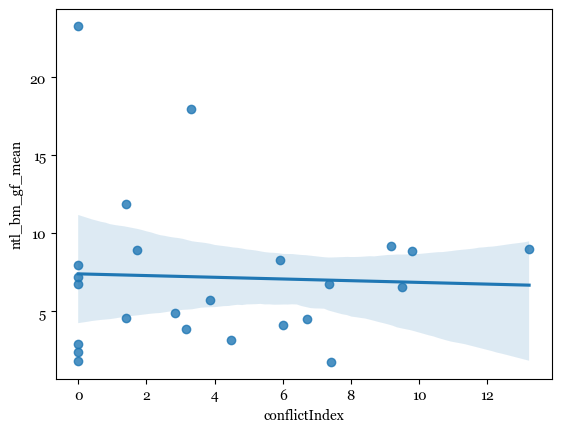

In [50]:
import seaborn as sns
sns.regplot(data = df, x=df['conflictIndex'], y=df['ntl_bm_gf_mean'])

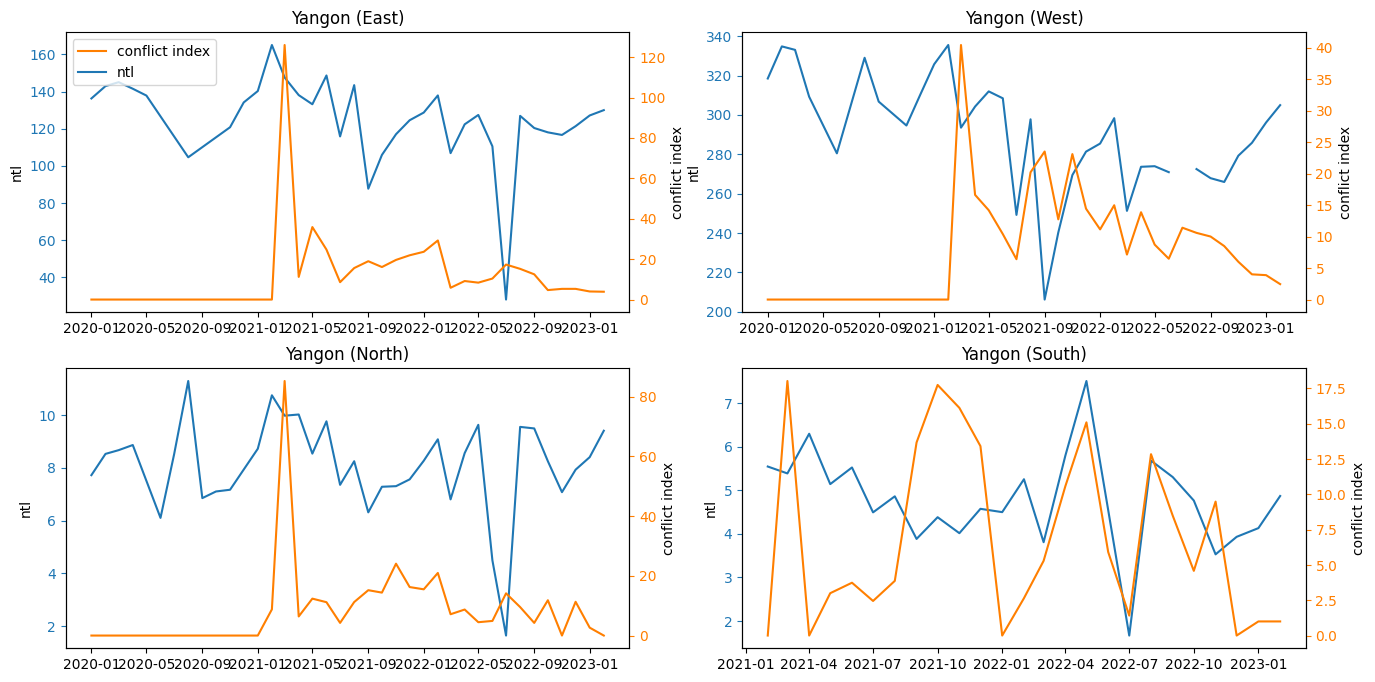

In [37]:
fig, axs = plt.subplots(2,2, figsize=(16,8))
ax=axs.flatten()

for i, ST in enumerate(['Yangon (East)', 'Yangon (West)', 'Yangon (North)', 'Yangon (South)']):
    df1 = df[df['NAME_2']==ST]
    ax[i].plot(df1['date'], df1['ntl_bm_mean'], '#1F77B4',label = 'ntl')
    ax[i].set_ylabel('ntl')
    ax[i].tick_params('y', colors='#1F77B4')

    ax1 = ax[i].twinx()
    ax1.plot(df1['date'], df1['conflictIndex'], '#FF7F00', label='conflict index')
    ax1.set_xlabel('x')
    ax1.set_ylabel('conflict index')
    ax1.tick_params('y', colors='#FF7F00')

    ax[i].spines['top'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

    lines = ax1.get_lines() + ax[i].get_lines()
    labels = [line.get_label() for line in lines]
    ax[0].legend(lines, labels, loc='upper left')
    

    ax[i].set_title(ST)